# Training

In [30]:
# Important libraries
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import random

# File paths
fp_notebooks_folder = "./"
fp_code_folder = "../"
fp_processed_folder = os.path.join(fp_code_folder, "../processed_data")
fp_downsampled_folder = os.path.join(fp_processed_folder, "downsampled")
fp_downsampled_dropna_file = os.path.join(fp_downsampled_folder, "dropna.csv")

# Check GPU is available
print(tf.config.list_physical_devices('GPU'))

# function to show df
def display_df(df):
    display(df.head())
    print("Shape:", df.shape)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load Data

In [5]:
df = pd.read_csv(fp_downsampled_dropna_file, index_col=0)
df

,ABPdias (mmHg) 0,ABPmean (mmHg) 0,ABPsys (mmHg) 0,HR (bpm) 0,RESP (bpm) 0,SpO2 (%) 0,ABPdias (mmHg) 1,ABPmean (mmHg) 1,ABPsys (mmHg) 1,HR (bpm) 1,...,SpO2 (%) 3,ABPdias (mmHg) 4,ABPmean (mmHg) 4,ABPsys (mmHg) 4,HR (bpm) 4,RESP (bpm) 4,SpO2 (%) 4,target,target_index,record
0,67.416667,84.800000,120.483333,63.850000,0.000000,96.300000,63.300000,86.033333,127.183333,83.416667,...,93.150000,86.066667,109.400000,156.550000,87.183333,0.000000,82.400000,False,9,048n
1,63.300000,86.033333,127.183333,83.416667,0.000000,93.600000,59.100000,83.350000,125.050000,82.466667,...,82.400000,85.716667,108.866667,158.133333,86.583333,0.000000,96.750000,False,10,048n
2,59.100000,83.350000,125.050000,82.466667,0.000000,93.366667,63.833333,88.850000,131.766667,83.950000,...,96.750000,88.466667,112.650000,160.550000,86.250000,0.000000,97.283333,False,11,048n
3,63.833333,88.850000,131.766667,83.950000,0.000000,93.150000,86.066667,109.400000,156.550000,87.183333,...,97.283333,103.750000,128.666667,181.050000,93.166667,0.000000,95.200000,False,12,048n
4,86.066667,109.400000,156.550000,87.183333,0.000000,82.400000,85.716667,108.866667,158.133333,86.583333,...,95.200000,101.116667,123.700000,174.750000,92.183333,0.000000,90.616667,False,13,048n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112560,51.000000,76.000000,131.733333,91.683333,21.733333,96.766667,50.050000,74.100000,126.983333,90.133333,...,96.333333,49.583333,74.633333,130.533333,90.933333,19.600000,96.000000,False,120058,476n
112561,50.050000,74.100000,126.983333,90.133333,21.766667,96.166667,50.833333,75.383333,131.400000,91.500000,...,96.000000,47.583333,73.350000,132.166667,91.850000,20.416667,96.733333,False,120059,476n
112562,50.833333,75.383333,131.400000,91.500000,20.966667,96.350000,50.200000,73.883333,128.050000,90.466667,...,96.733333,47.750000,73.750000,130.850000,92.300000,23.033333,97.000000,False,120060,476n
112563,50.200000,73.883333,128.050000,90.466667,18.866667,96.333333,49.583333,74.633333,130.533333,90.933333,...,97.000000,49.066667,76.933333,139.483333,92.533333,23.616667,97.116667,False,120061,476n


In [18]:
predictors = df.columns[:6*5].to_list()
print(predictors)

['ABPdias (mmHg) 0', 'ABPmean (mmHg) 0', 'ABPsys (mmHg) 0', 'HR (bpm) 0', 'RESP (bpm) 0', 'SpO2 (%) 0', 'ABPdias (mmHg) 1', 'ABPmean (mmHg) 1', 'ABPsys (mmHg) 1', 'HR (bpm) 1', 'RESP (bpm) 1', 'SpO2 (%) 1', 'ABPdias (mmHg) 2', 'ABPmean (mmHg) 2', 'ABPsys (mmHg) 2', 'HR (bpm) 2', 'RESP (bpm) 2', 'SpO2 (%) 2', 'ABPdias (mmHg) 3', 'ABPmean (mmHg) 3', 'ABPsys (mmHg) 3', 'HR (bpm) 3', 'RESP (bpm) 3', 'SpO2 (%) 3', 'ABPdias (mmHg) 4', 'ABPmean (mmHg) 4', 'ABPsys (mmHg) 4', 'HR (bpm) 4', 'RESP (bpm) 4', 'SpO2 (%) 4']


In [20]:
pred_col = "target"

In [14]:
# Make train, validation and test sets
def recordwise_train_valid_test_split(df, valid_prop, test_prop):
    records = df["record"].unique()
    num_records = len(records)
    record_indices = np.arange(num_records)
    np.random.shuffle(record_indices)
    shuffled_records = records[record_indices]
    num_valid, num_test = round(valid_prop * num_records), round(test_prop * num_records)
    num_train = num_records - num_valid - num_test
    train_records, valid_records, test_records = (
        shuffled_records[:num_train], shuffled_records[num_train: num_train+num_valid],
        shuffled_records[num_train+num_valid:num_train+num_valid+num_test],
    )
    train_df, valid_df, test_df = (
        df[df["record"].isin(train_records)], df[df["record"].isin(valid_records)],
        df[df["record"].isin(test_records)]
    )
    return train_df, valid_df, test_df

df_train, df_valid, df_test = recordwise_train_valid_test_split(df, valid_prop=0.1, test_prop=0.2)
display_df(df_train)
print(df_train["target"].value_counts())
display_df(df_valid)
print(df_valid["target"].value_counts())
display_df(df_test)
print(df_test["target"].value_counts())

,ABPdias (mmHg) 0,ABPmean (mmHg) 0,ABPsys (mmHg) 0,HR (bpm) 0,RESP (bpm) 0,SpO2 (%) 0,ABPdias (mmHg) 1,ABPmean (mmHg) 1,ABPsys (mmHg) 1,HR (bpm) 1,...,SpO2 (%) 3,ABPdias (mmHg) 4,ABPmean (mmHg) 4,ABPsys (mmHg) 4,HR (bpm) 4,RESP (bpm) 4,SpO2 (%) 4,target,target_index,record
0,67.416667,84.800000,120.483333,63.850000,0.0,96.300000,63.300000,86.033333,127.183333,83.416667,...,93.150000,86.066667,109.400000,156.550000,87.183333,0.0,82.400000,False,9,048n
1,63.300000,86.033333,127.183333,83.416667,0.0,93.600000,59.100000,83.350000,125.050000,82.466667,...,82.400000,85.716667,108.866667,158.133333,86.583333,0.0,96.750000,False,10,048n
2,59.100000,83.350000,125.050000,82.466667,0.0,93.366667,63.833333,88.850000,131.766667,83.950000,...,96.750000,88.466667,112.650000,160.550000,86.250000,0.0,97.283333,False,11,048n
3,63.833333,88.850000,131.766667,83.950000,0.0,93.150000,86.066667,109.400000,156.550000,87.183333,...,97.283333,103.750000,128.666667,181.050000,93.166667,0.0,95.200000,False,12,048n
4,86.066667,109.400000,156.550000,87.183333,0.0,82.400000,85.716667,108.866667,158.133333,86.583333,...,95.200000,101.116667,123.700000,174.750000,92.183333,0.0,90.616667,False,13,048n


Shape: (64952, 33)
target
False    57661
True      7291
Name: count, dtype: int64


,ABPdias (mmHg) 0,ABPmean (mmHg) 0,ABPsys (mmHg) 0,HR (bpm) 0,RESP (bpm) 0,SpO2 (%) 0,ABPdias (mmHg) 1,ABPmean (mmHg) 1,ABPsys (mmHg) 1,HR (bpm) 1,...,SpO2 (%) 3,ABPdias (mmHg) 4,ABPmean (mmHg) 4,ABPsys (mmHg) 4,HR (bpm) 4,RESP (bpm) 4,SpO2 (%) 4,target,target_index,record
6530,50.733333,86.483333,148.950000,68.216667,2.133333,97.000000,63.683333,104.850000,180.866667,88.45,...,96.983333,65.183333,107.516667,184.816667,88.950000,12.583333,96.200000,False,6698,211n
6531,63.683333,104.850000,180.866667,88.450000,8.583333,97.000000,62.700000,102.233333,177.266667,88.00,...,96.200000,66.266667,110.583333,188.800000,90.000000,12.516667,95.883333,False,6699,211n
6532,62.700000,102.233333,177.266667,88.000000,7.183333,97.000000,62.283333,102.150000,177.100000,88.00,...,95.883333,65.900000,109.883333,188.150000,90.000000,3.350000,95.866667,False,6700,211n
6533,62.283333,102.150000,177.100000,88.000000,7.483333,96.983333,65.183333,107.516667,184.816667,88.95,...,95.866667,65.550000,109.533333,188.183333,89.966667,8.250000,96.000000,False,6701,211n
6534,65.183333,107.516667,184.816667,88.950000,12.583333,96.200000,66.266667,110.583333,188.800000,90.00,...,96.000000,65.750000,109.833333,188.783333,89.416667,7.733333,96.000000,False,6702,211n


Shape: (5530, 33)
target
False    4963
True      567
Name: count, dtype: int64


,ABPdias (mmHg) 0,ABPmean (mmHg) 0,ABPsys (mmHg) 0,HR (bpm) 0,RESP (bpm) 0,SpO2 (%) 0,ABPdias (mmHg) 1,ABPmean (mmHg) 1,ABPsys (mmHg) 1,HR (bpm) 1,...,SpO2 (%) 3,ABPdias (mmHg) 4,ABPmean (mmHg) 4,ABPsys (mmHg) 4,HR (bpm) 4,RESP (bpm) 4,SpO2 (%) 4,target,target_index,record
2057,75.200000,110.450000,163.533333,92.866667,26.416667,95.950000,74.466667,108.983333,163.416667,91.433333,...,98.000000,68.950000,105.033333,161.500000,97.816667,26.516667,98.883333,False,2146,054n
2058,74.466667,108.983333,163.416667,91.433333,34.116667,95.866667,75.700000,110.250000,166.066667,87.816667,...,98.883333,70.966667,106.633333,163.300000,94.316667,26.333333,96.983333,False,2147,054n
2059,75.700000,110.250000,166.066667,87.816667,29.266667,98.250000,78.916667,114.800000,168.000000,90.350000,...,96.983333,67.666667,106.183333,168.950000,94.550000,44.733333,98.000000,False,2148,054n
2060,78.916667,114.800000,168.000000,90.350000,32.700000,98.000000,68.950000,105.033333,161.500000,97.816667,...,98.000000,67.400000,104.733333,166.983333,92.066667,36.716667,97.950000,False,2149,054n
2061,68.950000,105.033333,161.500000,97.816667,26.516667,98.883333,70.966667,106.633333,163.300000,94.316667,...,97.950000,66.850000,103.316667,165.733333,90.916667,35.083333,97.183333,False,2150,054n


Shape: (18216, 33)
target
False    17040
True      1176
Name: count, dtype: int64


## Model Definition

In [39]:
def set_seed(seed):
    tf.config.experimental.enable_op_determinism()
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def display_history(history, show_acc=False):
    if show_acc:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2.5))
        axes[0].plot(history.history['loss'])
        axes[0].plot(history.history['val_loss'])
        axes[0].set_title('Model Loss')
        axes[0].set_ylabel('Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].legend(['Train', 'Val'], loc='upper left')
        axes[1].plot(history.history['accuracy'])
        axes[1].plot(history.history['val_accuracy'])
        axes[1].set_title('Model Accuracy')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].legend(['Train', 'Val'], loc='upper left')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 2.5))
        axes.plot(history.history['loss'])
        axes.plot(history.history['val_loss'])
        axes.set_title('Model Loss')
        axes.set_ylabel('Loss')
        axes.set_xlabel('Epoch')
        axes.legend(['Train', 'Val'], loc='upper left')
    plt.tight_layout()
    plt.show()

class AE_Classifier:
    def __init__(self, width, predictors, num_class):
        from keras.layers import Dense
        self.predictors = predictors
        self.num_predictors = len(self.predictors)
        self.num_class = num_class
        self.width = width
        
        # Instantiate model layers
        self.inputs = tf.keras.Input(shape=(self.num_predictors,))
        self.encoder = Dense(
            self.width, activation=tf.keras.layers.LeakyReLU(alpha=0.3), name="encoder")
        self.decoder = Dense(self.num_predictors, name="decoder")
        if self.num_class > 2:
            self.classifier = Dense(self.num_class, activation="softmax", name="classifier")
        else:
            self.classifier = Dense(1, activation="sigmoid", name="classifier")
    
    # Smote is external
    def train_classifier(
        self, train_X, train_y, val_X, val_y, batch_size, max_epochs, verbose, patience):
        from tensorflow.keras.callbacks import EarlyStopping
        # Define classifier
        pred = self.encoder(self.inputs)
        pred = self.classifier(pred)
        self.predictor = tf.keras.Model(inputs=self.inputs, outputs=pred, name="classifier_model")
        if self.num_class == 2:
            # Train classifier
            self.predictor.compile(
                loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
            )
        else:
            # Train classifier
            self.predictor.compile(
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
            )
        es = EarlyStopping(
            monitor='val_loss', mode='min', verbose=1, patience=patience,restore_best_weights=True)
        self.predictor_history = self.predictor.fit(
            train_X, train_y, 
            epochs=max_epochs, 
            validation_data=(val_X, val_y),
            verbose=verbose,
            batch_size=batch_size,
            callbacks=[es]
        )
        print("- Classifier Training History")
        display_history(self.predictor_history, show_acc=True)
        best_index = np.argmin(self.predictor_history.history['val_loss'])
        
        return (
            self.predictor_history.history['val_loss'][best_index], 
            self.predictor_history.history['val_accuracy'][best_index]
        )
        
    def train_decoder(
        self, train_X, val_X, batch_size, max_epochs, verbose, patience):
        from tensorflow.keras.callbacks import EarlyStopping
        # Define AE
        self.encoder.trainable=False # Freeze weights
        x = self.encoder(self.inputs)
        x = self.decoder(x)
        self.ae = tf.keras.Model(inputs=self.inputs, outputs=x, name="ae_model")
        # Train AE
        self.ae.compile(
            loss="mse",
            optimizer=tf.keras.optimizers.Adam()
        )
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience,restore_best_weights=True)
        self.ae_history = self.ae.fit(
            train_X, train_X, 
            epochs=max_epochs, 
            validation_data=(val_X, val_X),
            verbose=verbose,
            batch_size=batch_size,
            callbacks=[es]
        )
        print("- Autoencoder Training History")
        display_history(self.ae_history)
        return min(self.ae_history.history['val_loss'])

    def predict(self, inputs, with_mae=False, round_dummies=True):
        # Encode
        encoder_output = self.encoder(inputs)

        # Reconstruct
        decoder_output = self.decoder(encoder_output).numpy()

        # Calculate reconstruction error
        mae = tf.math.abs(decoder_output - inputs)
        mae = tf.reduce_sum(mae, [-1])

        # Get forecast result
        classifier_output = self.classifier(encoder_output)

        if with_mae:
            return classifier_output, mae
        else:
            return classifier_output
        
def save_model(model, name, fp_checkpoints, override=False):
    import pickle
    model_folder = os.path.join(fp_checkpoints, name)
    if os.path.exists(model_folder):
        print("Model checkpoint already exists!")
        if not override:
            return
    else:
        os.makedirs(model_folder)
    
    # Save Parameters
    parameters_to_save = dict(
        predictors = model.predictors,
        num_class = model.num_class,
        width = model.width
    )   
    parameter_filename = os.path.join(fp_checkpoints, name, "parameters.pickle")
    with open(parameter_filename, 'wb') as handle:
        pickle.dump(parameters_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Save Model
    inputs = model.inputs
    encoder_output = model.encoder(inputs)
    decoder_output = model.decoder(encoder_output)
    classifier_output = model.classifier(encoder_output)
    model = tf.keras.Model(inputs, [classifier_output, decoder_output])
    model_filename = os.path.join(fp_checkpoints, name, "model.h5")
    model.save(model_filename)
    print("Model saved!")

def load_model(name, fp_checkpoints): 
    import pickle
    model_folder = os.path.join(fp_checkpoints, name)
    parameter_filename = os.path.join(fp_checkpoints, name, "parameters.pickle")
    model_filename = os.path.join(fp_checkpoints, name, "model.h5")
    
    if not os.path.exists(model_folder):
        print("model checkpoint does not exist!")
        return
    model = tf.keras.models.load_model(model_filename)
    with open(parameter_filename, 'rb') as handle:
        parameters = pickle.load(handle)
    
    ae_classifier = AE_Classifier(
        parameters["width"], parameters["predictors"], parameters["num_class"])
    ae_classifier.encoder = model.get_layer("encoder")
    ae_classifier.decoder = model.get_layer("decoder")
    ae_classifier.classifier = model.get_layer("classifier")
    
    return ae_classifier

def model_tuning(
    width_list, predictors, pred_col, num_class, train_df, valid_df, seed,
    batch_size=128, max_epochs=5000, verbose=1, patience=10):
    from imblearn.over_sampling import SMOTE
    train_X, train_y = train_df[predictors].values.astype('float32'), train_df[pred_col].values.astype('float32')
    valid_X, valid_y = valid_df[predictors].values.astype('float32'), valid_df[pred_col].values.astype('float32')
    loss_list = []
    acc_list = []
    time_spent_list = []
    for width in tqdm(width_list):
        set_seed(seed)
        classifier = AE_Classifier(width, predictors, num_class)
        start = time.time()
        # Oversample
        oversample = SMOTE()
        train_X_over, train_y_over = oversample.fit_resample(train_X, train_y)
        # Train classifier
        val_loss, val_acc = classifier.train_classifier(
            train_X_over, train_y_over, valid_X, valid_y, 
            batch_size, max_epochs, verbose, patience)
        # Train decoder (Tune by classifier loss only)
#             classifier.train_decoder(
#                 fold_train_X_over, fold_val_X, batch_size, max_epochs, verbose, patience)
        loss_list.append(val_loss)
        acc_list.append(val_acc)
        time_spent_list.append(time.time()-start)
    tuning_df = pd.DataFrame(
        {"width": width_list, "loss": loss_list, "acc": acc_list, "time/s": time_spent_list})
    best_width_idx = tuning_df['loss'].idxmin()
    best_width = tuning_df['width'].tolist()[best_width_idx]
    return tuning_df, best_width

def model_training(
    width, predictors, pred_col, num_class, train_df, test_df, seed,
    batch_size=128, max_epochs=5000, verbose=1, patience=10, k=5):
    from tqdm import tqdm
    import time
    from imblearn.over_sampling import SMOTE
    set_seed(seed)
    
    # Get data
    train_X, train_y = train_df[predictors].values.astype('float32'), train_df[pred_col].values.astype('float32')
    test_X, test_y = test_df[predictors].values.astype('float32'), test_df[pred_col].values.astype('float32')
    
    # Train classifier
    ae_classifier = AE_Classifier(width, predictors, predictor_types, num_class)

    # Oversample
    oversample = SMOTE()
    train_X_over, train_y_over = oversample.fit_resample(train_X, train_y)
    print(pd.Series(train_y_over).value_counts())
    
    start = time.time()
    # Train classifier
    test_loss_classifier, test_acc = ae_classifier.train_classifier(
        train_X_over, train_y_over, test_X, test_y, 
        batch_size, max_epochs, verbose, patience)
    
    # Train decoder
    test_loss_ae = ae_classifier.train_decoder(
        train_X_over, test_X, batch_size, max_epochs, verbose, patience)
    
    print(f"Training took {time.time()-start}s.")
    print(f"Test Classifier Accuracy: {test_acc}, Test Classifier Loss: {test_loss_classifier}")
    print(f"Test Autoencoder Loss: {test_loss_ae}")
    return ae_classifier

  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch 1/10000
901/901 [==============================] - 1s 1ms/step - loss: 1.2603 - accuracy: 0.5897 - val_loss: 0.4601 - val_accuracy: 0.8273
Epoch 2/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.8504 - accuracy: 0.6231 - val_loss: 0.4658 - val_accuracy: 0.7955
Epoch 3/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.7553 - accuracy: 0.6469 - val_loss: 0.7696 - val_accuracy: 0.5233
Epoch 4/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.6949 - accuracy: 0.6587 - val_loss: 0.6122 - val_accuracy: 0.6485
Epoch 5/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.6550 - accuracy: 0.6731 - val_loss: 0.4433 - val_accuracy: 0.8076
Epoch 6/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.6225 - accuracy: 0.6861 - val_loss: 0.5085 - val_accuracy: 0.7834
Epoch 7/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.6103 - accuracy: 0.6923 - val_loss: 0.7443 - val_ac

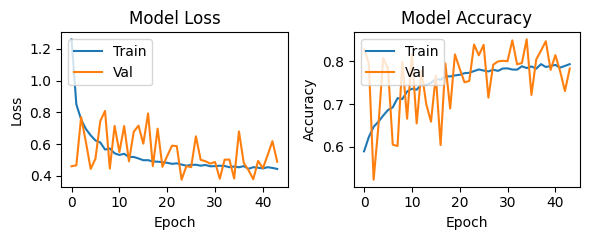

 20%|█████████                                    | 1/5 [00:44<02:57, 44.43s/it]

Epoch 1/10000
901/901 [==============================] - 3s 3ms/step - loss: 1.4449 - accuracy: 0.5957 - val_loss: 1.0402 - val_accuracy: 0.5018
Epoch 2/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.7578 - accuracy: 0.6380 - val_loss: 0.5518 - val_accuracy: 0.7289
Epoch 3/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.7009 - accuracy: 0.6562 - val_loss: 0.9543 - val_accuracy: 0.4521
Epoch 4/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.6490 - accuracy: 0.6698 - val_loss: 0.8685 - val_accuracy: 0.4369
Epoch 5/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.6216 - accuracy: 0.6837 - val_loss: 1.0208 - val_accuracy: 0.3854
Epoch 6/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.5819 - accuracy: 0.7036 - val_loss: 0.5417 - val_accuracy: 0.7667
Epoch 7/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.5767 - accuracy: 0.7082 - val_loss: 0.9367 - val_ac

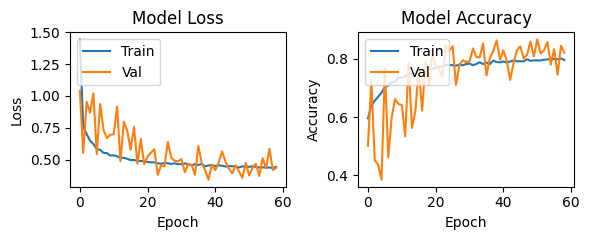

 40%|██████████████████                           | 2/5 [01:45<02:42, 54.18s/it]

Epoch 1/10000
901/901 [==============================] - 1s 1ms/step - loss: 1.4747 - accuracy: 0.5903 - val_loss: 0.5301 - val_accuracy: 0.8967
Epoch 2/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.7762 - accuracy: 0.6333 - val_loss: 0.4800 - val_accuracy: 0.8177
Epoch 3/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.7026 - accuracy: 0.6553 - val_loss: 1.1650 - val_accuracy: 0.3544
Epoch 4/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.6538 - accuracy: 0.6688 - val_loss: 0.7194 - val_accuracy: 0.5673
Epoch 5/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.6290 - accuracy: 0.6788 - val_loss: 0.9515 - val_accuracy: 0.4108
Epoch 6/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.5822 - accuracy: 0.7032 - val_loss: 0.5336 - val_accuracy: 0.7749
Epoch 7/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.5691 - accuracy: 0.7125 - val_loss: 0.9898 - val_ac

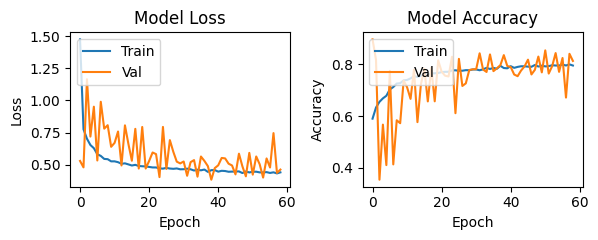

 60%|███████████████████████████                  | 3/5 [02:44<01:53, 56.56s/it]

Epoch 1/10000
901/901 [==============================] - 1s 1ms/step - loss: 1.4697 - accuracy: 0.5874 - val_loss: 0.8361 - val_accuracy: 0.5425
Epoch 2/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.7858 - accuracy: 0.6320 - val_loss: 0.3944 - val_accuracy: 0.8892
Epoch 3/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.7327 - accuracy: 0.6465 - val_loss: 1.0087 - val_accuracy: 0.4358
Epoch 4/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.6364 - accuracy: 0.6719 - val_loss: 0.9952 - val_accuracy: 0.3056
Epoch 5/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.6248 - accuracy: 0.6791 - val_loss: 0.8453 - val_accuracy: 0.4761
Epoch 6/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.5848 - accuracy: 0.7006 - val_loss: 0.6045 - val_accuracy: 0.7257
Epoch 7/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.5680 - accuracy: 0.7114 - val_loss: 0.9788 - val_ac

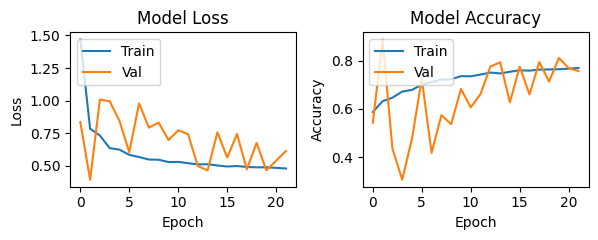

 80%|████████████████████████████████████         | 4/5 [03:07<00:43, 43.16s/it]

Epoch 1/10000
901/901 [==============================] - 2s 2ms/step - loss: 1.4201 - accuracy: 0.5871 - val_loss: 0.4283 - val_accuracy: 0.8975
Epoch 2/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.8444 - accuracy: 0.6240 - val_loss: 0.4109 - val_accuracy: 0.8671
Epoch 3/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.7001 - accuracy: 0.6533 - val_loss: 1.1676 - val_accuracy: 0.3535
Epoch 4/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.6417 - accuracy: 0.6691 - val_loss: 0.8651 - val_accuracy: 0.4114
Epoch 5/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.6165 - accuracy: 0.6832 - val_loss: 0.8259 - val_accuracy: 0.5045
Epoch 6/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.5864 - accuracy: 0.6991 - val_loss: 0.6532 - val_accuracy: 0.6608
Epoch 7/10000
901/901 [==============================] - 1s 1ms/step - loss: 0.5565 - accuracy: 0.7182 - val_loss: 1.0028 - val_ac

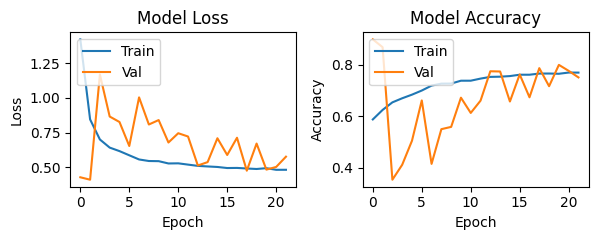

100%|█████████████████████████████████████████████| 5/5 [03:30<00:00, 42.08s/it]


In [40]:
tuning_df, best_width = model_tuning(
    width_list=[1024, 1280, 1536, 1792, 2048], predictors=predictors, pred_col=pred_col, 
    num_class=2, train_df=df_train, valid_df=df_valid, seed=2023,
    batch_size=128, max_epochs=10000, verbose=1, patience=20
)

In [41]:
tuning_df

,width,loss,acc,time/s
0,1024,0.375310,0.839060,44.404215
1,1280,0.341509,0.863110,60.994474
2,1536,0.384202,0.835805,59.388041
3,1792,0.394420,0.889150,22.624894
4,2048,0.410893,0.867089,22.919188
